# Practical Assignment — Machine learning on graphs

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
from IPython.display import clear_output
from tqdm.notebook import tqdm
import requests

In [ ]:
url = 'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_ml_on_graphs/569720_ego_pokec.gml'
open('569720_ego_pokec.gml', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_ml_on_graphs/musae_facebook_ego_802.gml'
open('musae_facebook_ego_802.gml', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_ml_on_graphs/polblogs.gml'
open('polblogs.gml', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_ml_on_graphs/email-Eu-core-temporal.txt'
open('email-Eu-core-temporal.txt', 'wb').write(requests.get(url).content)


### Task 1. Assortativity analysis (1 point)

If the structure of the network is known but the labels of the nodes are hidden, we would like to select a small subset of nodes such that, if we knew their labels, we could accurately predict the labels of all the other nodes. However, it makes sence if labels depend of network structure. A few next models work well upon the assumption of high assortativity mixing. Let us remind that assortative mixing is the tendency for nodes to be connected to other nodes that are like them in some way. Assortativity coefficient bounded by

$$-1 \leq r \leq 1$$

where $r \to -1$ means that nodes tend to connect to nodes of the another class, $r \to 1$ — to the same class. Therefore, randomly mixed networks show $r \to 0$ for binary and numeric features, and $r < 0$ for categorical features. 

First, let us check assortativity coefficient for some networks and try to understand which labels can be predicted via network structure.

Write a function `assortativity_coefficients` that takes a graph, an optional list of categorical (or binary) features, an optional list of numerical features and returns a dictionary where a key is a feature name and value is assoratitvity coefficient. _Use `nx.attribute_assortativity_coefficient` and `nx.numeric_assortativity_coefficient`._

In [5]:
def assortativity_coefficients(G, categorical=[], numerical=[]):
    result = {}
    for cat in categorical:
        result[cat] = nx.attribute_assortativity_coefficient(G, cat)
    for num in numerical:
        result[num] = nx.numeric_assortativity_coefficient(G, num)
        
    return result

Here is a subgraph of Slovakian online social network [Pokec](http://snap.stanford.edu/data/soc-Pokec.html)

In [6]:
G = nx.read_gml('569720_ego_pokec.gml')
coef = assortativity_coefficients(
    G, ['public', 'gender', 'region'], ['age', 'completion_percentage'])
assert len(coef) == 5
assert round(sum(coef.values()), 4) == 0.2832

In [7]:
pd.DataFrame(coef, index=['assortativity']).T.round(2)

,assortativity
public,-0.36
gender,0.09
region,0.26
age,0.24
completion_percentage,0.05


* `public` is 1 if a person publishes his list of friends, and 0 otherwise
* `gender` is 1 for male and 0 for female
* `region` is a region of residence
* `age` is integer age
* `completion_percentage` is a percentage of completion information about a person

Next, look at a network of [political blogosphere in the 2004 US Election](http://www-personal.umich.edu/~mejn/netdata/)

In [8]:
G = nx.read_gml('polblogs.gml')
coef = assortativity_coefficients(G, ['leaning', 'source'])
pd.DataFrame(coef, index=['assortativity']).T.round(2)

,assortativity
leaning,0.82
source,0.02


Political blogs leaning are divided into liberal and conservative. Also there is a `source` where this information taken from.

Next, look at subgraph of the [Facebook large page-page network](http://snap.stanford.edu/data/facebook-large-page-page-network.html) restricted to pages from 4 categories which are defined by Facebook. These categories are: politicians, governmental organizations, television shows and companies.

In [9]:
G = nx.read_gml('musae_facebook_ego_802.gml')
coef = round(assortativity_coefficients(G, ['value'])['value'], 2)
print('category:', coef)

category: 0.78


Another way to check numeric features is to calculate correlation of nodes attributes by edges. Let us again loook at attribute `age` in Pokec network. Let us draw a scatterplot with edges where $x$ is an age of the first node and $y$ is an age of the second node in each edge.

Write a function `age_by_edges` that takes Pokec network and returns a tuple of two np.arrays:
* age of the first node in edge
* age of the second node in edge

Size of each array is the number of edges.

In [15]:
def age_by_edges(G):
    x = []
    y = []
    for u, v in G.edges:
        x.append(G.nodes[u]['age'])
        y.append(G.nodes[v]['age'])
    return np.array(x), np.array(y)

In [16]:
G = nx.read_gml('569720_ego_pokec.gml')
x, y = age_by_edges(G)
corrcoef = np.corrcoef(x, y)[0, 1]
assert round(corrcoef, 4) == 0.2422

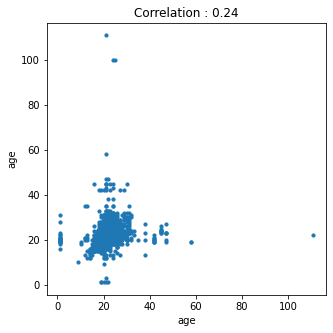

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=10)
plt.title('Correlation : {:.2f}'.format(corrcoef))
plt.xlabel('age')
plt.ylabel('age')
plt.show()

Also it could be useful to transform a graph into bipartite and try to find a stronger dependency. For example, let us look at attribute `age` in edges that connect nodes with opposite `gender`.

Write a function `age_by_gender` that takes Pokec network and returns a tuple of two np.arrays:
* age of a male node in edge (`gender = 1`)
* age of a female node in edge

Size of each array is the number of edges that connect nodes with opposite `gender`.

In [20]:
def age_by_gender(G):
    x = []
    y = []
    for u, v in G.edges:
        u, v = G.nodes[u], G.nodes[v]
        if u['gender'] != v['gender']:
            if v['gender'] == 1:
                u, v = v, u
        else:
            continue
        x.append(u['age'])
        y.append(v['age'])
    return np.array(x), np.array(y)

In [21]:
x, y = age_by_gender(G)
corrcoef = np.corrcoef(x, y)[0, 1]
assert round(corrcoef, 4) == 0.2214

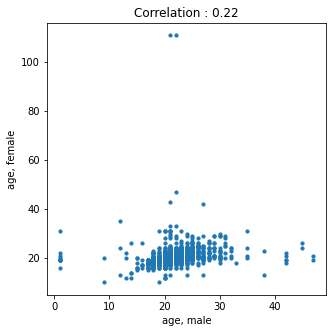

In [22]:
plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=10)
plt.title('Correlation : {:.2f}'.format(corrcoef))
plt.xlabel('age, male')
plt.ylabel('age, female')
plt.show()

Now we can find and drop outliers to increase correlation. For example, there are two significant outliers in the area $y>100$.

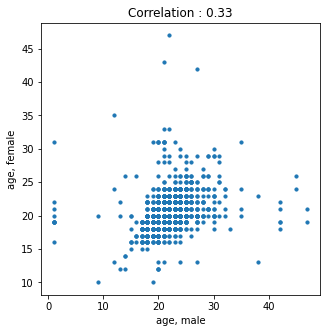

In [23]:
plt.figure(figsize=(5, 5))
plt.scatter(x[y < 100], y[y < 100], s=10)
plt.title(
    'Correlation : {:.2f}'.format(np.corrcoef(x[y < 100], y[y < 100])[0, 1])
)
plt.xlabel('age, male')
plt.ylabel('age, female')
plt.show()

### Task 2. Relational Neighbor Classifier (1 points)

Now let us start again with the facebook dataset and try to predict a page category (0.78 assortativity coefficient): politicians, governmental organizations, television shows and companies.

In [24]:
G = nx.read_gml('musae_facebook_ego_802.gml')
G = nx.convert_node_labels_to_integers(G)

Prepare train and test sets of nodes to classification. Let us randomly select 30% of nodes as a train set.

In [25]:
np.random.seed(0)
train_nodes = np.random.choice(G, size=int(0.3 * len(G)), replace=False)
test_nodes = np.array(list(set(G.nodes).difference(train_nodes)))

values = np.array(list(nx.get_node_attributes(G, 'value').values()))
y_train_temp = values[train_nodes]
y_test_temp = values[test_nodes]

print(y_train_temp[:10])

['government' 'politician' 'politician' 'politician' 'politician'
 'politician' 'tvshow' 'government' 'government' 'government']


Convert labels into integers for simplicity

In [26]:
unique = list(set(values))
y_train = np.array([unique.index(val) for val in y_train_temp])
y_test = np.array([unique.index(val) for val in y_test_temp])
print(y_train[:10])

[1 3 3 3 3 3 0 1 1 1]


Let us denote $y_i$ as label of node $i$. Relational Neighbor Classifier based on a simple iterative procedure

$$P(y_i = c|\mathcal N(i)) = \frac{1}{Z}\sum_{j \in \mathcal N(i)}A_{ij}P(y_j = c|\mathcal N(j))$$

where $Z$ is a normalizing constant, $\mathcal N(i)$ is neighbors of node $i$. Note that this approuch based on an assumption of strong assortativity: nodes related to each other are similar and likely belong to the same class. The algorithm is:

1. Set an initial conditional distribution $\Phi_0$. Train nodes have a probability one in truth class and zeros in others. Test nodes have an equal probability of each class.
2. Update $\Phi$ only for test nodes by the equation above
3. Repeat 2 until converges: $\Vert \Phi_{i+1} - \Phi_i \Vert < \varepsilon$
4. Predictions are labels with maximal probability

There is a function `relational_neighbor` that predicts labels. Parameters are:
* `G`: graph
* `threshold`: convergence threshold
* `y_train`: np.array, labels for train nodes
* `train_nodes`: np.array, train nodes
* `test_nodes`: np.array, test nodes

The function returns a np.array with labels for test nodes and np.array of norms of a distributions difference in each step before convergence.

In [27]:
def relational_neighbor(G, threshold, y_train, train_nodes, test_nodes):
    conditional = initial_conditional(G, y_train, train_nodes, test_nodes)
    diffs = []
    while True:

        next_conditional = update_conditional(G, conditional, test_nodes)
        diff = np.linalg.norm(conditional[test_nodes] - next_conditional[test_nodes])
        if diff < threshold:
            break
        diffs.append(diff)
        conditional = next_conditional
        
        if len(diffs) > 1:
            plt.plot(diffs)
            plt.xlabel('Step')
            plt.ylabel('Difference')
            plt.title('Convergence')
            plt.show()
            clear_output(wait=True)
        
    return np.argmax(conditional[test_nodes], axis=1), diffs

Write a function `initial_conditional` that returns np.array with initial conditional distribution where $i$-th row represents probability of belonging of node $i$ to each class. Parameters are the same.

In [34]:
def initial_conditional(G, y_train, train_nodes, test_nodes):
    n_classes = len(np.unique(y_train))
    conditional = []
    for i, node in enumerate(train_nodes):
        probs = np.zeros(n_classes)
        probs[y_train[i]] = 1
        conditional.append((node, probs))
    
    for node in test_nodes:
        probs = np.ones(n_classes) / n_classes
        conditional.append((node, probs))
    
    conditional = sorted(conditional, key=lambda pair: pair[0])
    conditional = np.array(list(map(lambda pair: pair[1], conditional)))
    
    return conditional

In [35]:
conditional = initial_conditional(G, y_train, train_nodes, test_nodes)
assert conditional.shape == (3873, 4)
assert np.all(conditional.sum(axis=1) == 1)
assert np.all(conditional[test_nodes] == 0.25)
assert set(np.unique(conditional[train_nodes])) == {0, 1}

Write a function `update_conditional` that updates and returns np.array with conditional distribution.

In [43]:
def update_conditional(G, conditional, test_nodes):
    new_conditional = conditional.copy()
    for node in test_nodes:
        probs = np.zeros(conditional.shape[1])
        for v in G.neighbors(node):
            probs += conditional[v]
        probs /= probs.sum()
        new_conditional[node] = probs
        
    return new_conditional

In [44]:
conditional = update_conditional(G, conditional, test_nodes)
assert conditional.shape == (3873, 4)
assert np.all(conditional.sum(axis=1).round(4) == 1)
assert set(np.unique(conditional[train_nodes])) == {0, 1}

An animation of convergence of the algorithm

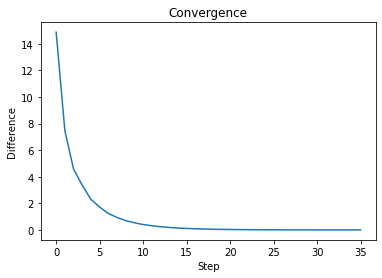

In [45]:
y_pred, diffs = relational_neighbor(G, 0.001, y_train, train_nodes, test_nodes)
score = balanced_accuracy_score(y_test, y_pred)
assert len(diffs) < 40
assert score > 0.7

In [46]:
print('Balanced accuracy:', round(score, 4))

Balanced accuracy: 0.7023


For comparison, a random guess is

In [47]:
score = balanced_accuracy_score(
    y_test, 
    np.random.choice(range(4), size=len(test_nodes), replace=True))
print('Balanced accuracy:', round(score, 4))

Balanced accuracy: 0.2558


### Task 3. Label propagation by random walks (2 points)

Consider the label propagation algorithm on an artificial dataset consisting of 3 sinusoids with noise.

In [48]:
N = 600
np.random.seed(0)
x_space = np.linspace(0, 3 * np.pi, int(N/3))
x1 = x_space + np.random.normal(0, 0.2, x_space.shape[0])
y1 = np.sin(x_space) + np.random.normal(0, 0.2, x_space.shape[0])
x2 = x_space + np.random.normal(0, 0.2, x_space.shape[0])
y2 = np.sin(x_space) + np.random.normal(0, 0.2, x_space.shape[0]) - 1.3
x3 = x_space + np.random.normal(0, 0.2, x_space.shape[0])
y3 = np.sin(x_space) + np.random.normal(0, 0.2, x_space.shape[0]) - 2.6

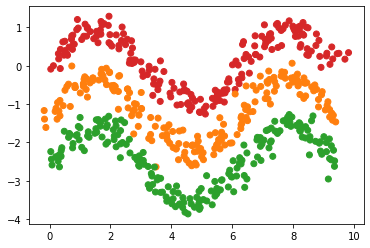

In [49]:
data_points = np.stack([np.concatenate([x1, x2, x3]), 
                        np.concatenate([y1, y2, y3])], axis=1)
plt.scatter(data_points[:, 0], data_points[:, 1], 
            c=np.repeat(['tab:red', 'tab:orange', 'tab:green'], 200));

Build a graph of k-neighbors of the data points.

In [50]:
A = kneighbors_graph(data_points, n_neighbors=8)
G = nx.Graph(A)
pos = {i:loc for i, loc in enumerate(data_points)}

Select 20 random train nodes. The goal is to predict an index of the sinusoid for other nodes.

In [51]:
np.random.seed(0)
train_nodes = np.random.choice(G, size=20, replace=False)
test_nodes = np.array(list(set(range(N)).difference(train_nodes)))

In [52]:
labels = np.array([0] * 200 + [1] * 200 + [2] * 200)
y_train = labels[train_nodes]
y_test = labels[test_nodes]

Draw the graph where train nodes are highlighted by colors with respect to a label.

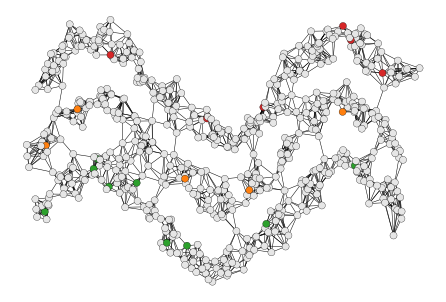

In [53]:
node_color = np.ones((len(G), 3)) * 0.9
node_color[train_nodes[y_train == 0]] = plt.cm.tab10(3)[:3]
node_color[train_nodes[y_train == 1]] = plt.cm.tab10(1)[:3]
node_color[train_nodes[y_train == 2]] = plt.cm.tab10(2)[:3]
nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)

Label propagation method is also assume that closer data points tend to have similar class labels. Let us denote $Y$ as given label matrix, whose $i$-th row representing the label probability distribution of node $i$. Initialization of rows corresponding to unlabeled data points is not important, but let it be a uniform distribution. The algorithm is
1. Propagate $Y \leftarrow PY$ where $P$ is a transition matrix
2. Recover rows of $Y$ corresponding to labeled data points
3. Row-normalize $Y$ to maintain probability interpretation
4. Repeat 1-3 until $Y$ converges
5. Make a prediction as the most likely labels 

Here is a function `label_propagation` that returns predicted labels. Parameters are the same as in the previuos task.

In [62]:
def label_propagation(G, threshold, y_train, train_nodes, test_nodes):
    Y = initital_Y(G, y_train, train_nodes, test_nodes)
    P = transition_matrix(G)
    while True:
        nextY = update_Y(P, Y, y_train, train_nodes, test_nodes)
        if np.linalg.norm(nextY - Y) < threshold:
            break
        Y = nextY
    y_pred = np.argmax(Y, axis=1)[test_nodes]
    return y_pred

Write a function `initital_Y` that returns np.array with initial label matrix. Parameters are the same.

In [54]:
def initital_Y(G, y_train, train_nodes, test_nodes):
    n_classes = len(np.unique(y_train))
    conditional = []
    for i, node in enumerate(train_nodes):
        probs = np.zeros(n_classes)
        probs[y_train[i]] = 1
        conditional.append((node, probs))
    
    for node in test_nodes:
        probs = np.ones(n_classes) / n_classes
        conditional.append((node, probs))
    
    conditional = sorted(conditional, key=lambda pair: pair[0])
    conditional = np.array(list(map(lambda pair: pair[1], conditional)))
    
    return conditional

In [55]:
Y = initital_Y(G, y_train, train_nodes, test_nodes)
assert Y.shape == (len(G), len(set(y_train)))
assert np.all(Y.sum(axis=1) == 1)
assert Y[train_nodes].max() == 1
assert Y[train_nodes].min() == 0

Write a function `transition_matrix` that returns np.array with transition matrix.

In [56]:
def transition_matrix(G):
    A = nx.adjacency_matrix(G)
    D = np.diag(list(dict(nx.degree(G)).values()))
    return np.linalg.inv(D) @ A

In [57]:
P = transition_matrix(G)
assert P.shape == (len(G), len(G))
assert np.all(P.sum(axis=1).round(4) == 1)

Write a function `update_Y` that returns np.array with updated label matrix.

In [60]:
def update_Y(P, Y, y_train, train_nodes, test_nodes):
    new_Y = P @ Y
    new_Y[train_nodes] = Y[train_nodes]
    new_Y /= new_Y.sum(axis=1, keepdims=True)
    return new_Y

In [63]:
nextY = update_Y(P, Y, y_train, train_nodes, test_nodes)
assert nextY.shape == (len(G), len(set(y_train)))
assert np.all(nextY.sum(axis=1).round(4) == 1)
assert nextY[train_nodes].max() == 1
assert nextY[train_nodes].min() == 0

y_pred = label_propagation(G, 0.001, y_train, train_nodes, test_nodes)
assert balanced_accuracy_score(y_test, y_pred) > 0.93

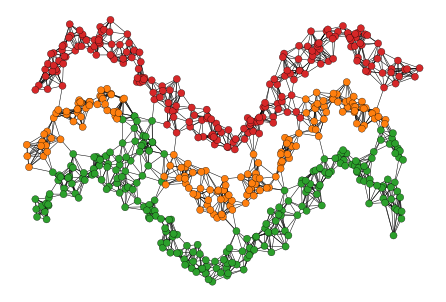

In [64]:
node_color[test_nodes[y_pred == 0]] = plt.cm.tab10(3)[:3]
node_color[test_nodes[y_pred == 1]] = plt.cm.tab10(1)[:3]
node_color[test_nodes[y_pred == 2]] = plt.cm.tab10(2)[:3]
nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)

### Task 4. Tikhonov regularization on graphs (2 points)

Consider node regression with Tikhonov ($L_2$, Ridge) regularization on an artificial dataset that was again converted into graph by k-neighbors.

In [65]:
N = 600
data_points, labels = make_moons(n_samples=N, noise=0.15, random_state=0)
A = kneighbors_graph(data_points, n_neighbors=5).toarray()
G = nx.Graph(A)
pos = {i:loc for i, loc in enumerate(data_points)}

In [66]:
np.random.seed(0)
train_nodes = np.random.choice(G, size=20, replace=False)
test_nodes = np.array(list(set(range(N)).difference(train_nodes)))
labels[labels == 0] = 10
labels[labels == 1] = 100
y_train = labels[train_nodes]
y_test = labels[test_nodes]

Here are labels of blue nodes equal to 10, reds equal to 100. Other labels are unknown.

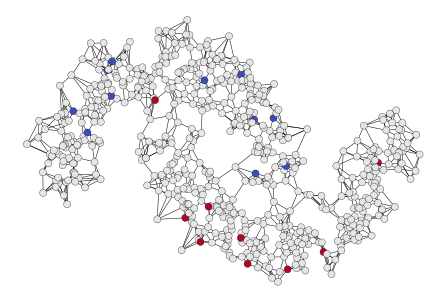

In [67]:
node_color = np.ones((len(G), 3)) * 0.9
node_color[train_nodes[y_train == 10]] = plt.cm.coolwarm(0)[:3]
node_color[train_nodes[y_train == 100]] = plt.cm.coolwarm(255)[:3]
nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)

Consider given node labels $\mathbf y$ and normalized labels

$$\tilde y_i = y_i - \frac{1}{k}\sum_{j=1}^k y_j$$ 

where $k$ is the number of known labels. Unknown labels are given as zeros $\tilde y_i = 0$. Also let $\mathbf f$ be predicted labels of nodes. The objective is to minimize the square loss function plus the smoothness penalty

$$\mathbf{\tilde f} = \text{argmin}_\mathbf{f}\left(\frac{1}{k}\sum_{i=1}^k(f_i - \tilde y_i)^2 + \gamma \mathbf{f}^T L \mathbf{f}\right)$$

where $L$ is a graph Laplacian. The analytical solution is given as

$$\mathbf{\tilde f} = (k \gamma L + I)^{-1}\mathbf{\tilde y}$$

where $I$ is a diagonal matrix with ones and zeros. $I_{ii} = 1$ if a label of $i$-th node is known.

_Remark: for the stability of the algorithm, we use $\tilde y_i$ instead of $y_i$._

Write a function `tikhonov_regularization` that takes the same parameters as above (`gamma` is a coefficient of regularization), and returns predicted labels.

In [142]:
def tikhonov_regularization(G, gamma, y_train, train_nodes, test_nodes):
    k = len(train_nodes)
    
    y_norm = np.zeros(len(G.nodes))
    mean_y = np.mean(y_train)
    y_norm[train_nodes] = y_train - mean_y
    
    A = nx.adjacency_matrix(G).toarray()
    D = np.diag(A.sum(axis=1))
    L = D - A
    
    E = np.zeros_like(L)
    E[train_nodes, train_nodes] = 1
    
    f_norm = np.linalg.inv(k * gamma * L + E) @ y_norm
    f_norm = np.array(f_norm)
    
    return f_norm[test_nodes] + mean_y

In [143]:
y_pred = tikhonov_regularization(G, 0.001, y_train, train_nodes, test_nodes)
assert mean_squared_error(y_test, y_pred) < 282

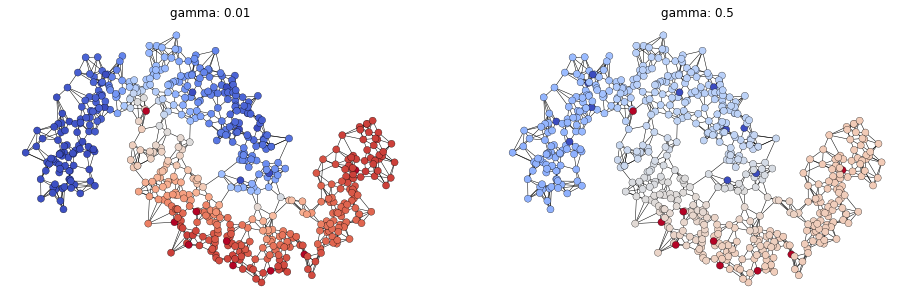

In [146]:
plt.figure(figsize=(16, 5))

for i, gamma in enumerate([0.01, 0.5]):
    y_pred = tikhonov_regularization(G, gamma, y_train, train_nodes, test_nodes)
    node_color = labels
    node_color[test_nodes] = y_pred
    plt.subplot(1, 2, i+1)
    nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
            node_color=node_color, edgecolors='black', cmap=plt.cm.coolwarm)
    plt.title('gamma: {}'.format(gamma))

### Task 5. Similarity based link prediction (2 points)

Consider link prediction on the [e-mails network](http://snap.stanford.edu/data/email-Eu-core-temporal.html) where nodes are members of a research institution and edges are e-mails given with timestamps. The goal is to predict occurrence of edges in the test time period using information from the train time period only.

In [147]:
email_df = pd.read_csv(
    'email-Eu-core-temporal.txt', 
    delimiter=' ', 
    names=['sender', 'receiver', 'timestamp']
)
email_df.head()

,sender,receiver,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


Next, consider the following preprocessing procedure:
1. Select edges by given train and test time periods, for example, [0, 1000) is train and [1000, 2000) is test
2. Build a _core_ — a network where every edge occurs at least $k_\text{train}$ times in the train time period or at least $k_\text{test}$ times in the test time period. Let the core be undirected, so occurrences edges (1, 0) and (0, 1) are computed together.
3. From the core, select a train set of edges $E_\text{train}$ that occur for the first time in the train period. All others are included to $E_\text{test}$.

Write a function `train_test_edges` that takes a pd.DataFrame `email_df` with e-mail network, a tuple with the train time period borders `train_period`, say, (0, 1000), a similar tuple `test_period`, the number of edges occurrences `ktrain` and `ktest`. The function returns two lists with tuples — train and test edges. Every edge is returned of the form where the first node is less than the second, for example [(1, 2), (2, 3)] is ok, but [(2, 1), (3, 2)] is wrong.

In [150]:
def train_test_edges(email_df, train_period, test_period, ktrain, ktest):
    may_be_train = (email_df['timestamp'] >= train_period[0]) & (email_df['timestamp'] < train_period[1])
    may_be_test = (email_df['timestamp'] >= test_period[0]) & (email_df['timestamp'] < test_period[1])
    
    core_edges = set()
    train_edges = set()
    test_edges = set()
    
    train_edges_counter = {}
    for _, row in email_df[may_be_train].iterrows():
        edge = tuple(sorted([row['sender'], row['receiver']]))
        train_edges_counter[edge] = train_edges_counter.get(edge, 0) + 1
        
    for edge, count in train_edges_counter.items():
        if count >= ktrain:
            core_edges.add(edge)
    
    test_edges_counter = {}
    for _, row in email_df[may_be_test].iterrows():
        edge = tuple(sorted([row['sender'], row['receiver']]))
        test_edges_counter[edge] = test_edges_counter.get(edge, 0) + 1
        
    for edge, count in test_edges_counter.items():
        if count >= ktest:
            core_edges.add(edge)
            
    
    for _, row in email_df[may_be_train].iterrows():
        edge = tuple(sorted([row['sender'], row['receiver']]))
        if edge in core_edges:
            train_edges.add(edge)
    
    for _, row in email_df[may_be_test].iterrows():
        edge = tuple(sorted([row['sender'], row['receiver']]))
        if edge in core_edges and edge not in train_edges:
            test_edges.add(edge)
    
    return list(train_edges), list(test_edges)

In [151]:
train_edges, test_edges = train_test_edges(email_df, (1e7, 2e7), (2e7, 2.5e7), 3, 3)
_train_edges, _test_edges = np.array(train_edges), np.array(test_edges)
assert np.all(_train_edges[:, 0] < _train_edges[:, 1])
assert np.all(_test_edges[:, 0] < _test_edges[:, 1])
assert len(set(train_edges).intersection(test_edges)) == 0
assert _train_edges.shape == (4147, 2)
assert _test_edges.shape == (418, 2)

The similarity based algorithm:
1. Compute similarity matrix for all pairs of nodes except $E_\text{train}$
2. Order that pairs in descending of similarity
3. Select some threshold and predict links for all pairs above the threshold

Write a function `sim_link_prediction` that takes a list with train edges and test edges. The function predicts links and returns a tuple with metrics: 
* two np.arrays: FPR (false positive rate) and TPR (true positive rate) in descending of thresholds obtained by Jaccard coefficient, `nx.jaccard_coefficient`
* the same, by Adamic/Adar index, `nx.adamic_adar_index`
* the same, by resource allocation index, `nx.resource_allocation_index`

_Hint: use `sklearn.metrics.roc_curve`._

In [210]:
[1]*3 + [2, 3]

[1, 1, 1, 2, 3]

In [218]:
def sim_link_prediction(train_edges, test_edges):
    G = nx.from_edgelist(train_edges)
    nodes = set(list(G.nodes()) + [node for edge in test_edges for node in edge])
#     nodes = G.nodes()
    
    not_train_edges = sorted([
        (i, j)
        for i in G.nodes()
        for j in G.nodes()
        if i < j and not (i, j) in G.edges()
    ])
    other_edges = sorted([
        (i, j)
        for i in nodes
        for j in nodes
        if i < j and (i not in G.nodes() or j not in G.nodes())
    ])
    n_not_in_train = len(other_edges)
    y_true = [1 if edge in test_edges else 0 for edge in not_train_edges + other_edges]
    
    
    
    y_pred = [p for u, v, p in sorted(nx.jaccard_coefficient(G, not_train_edges))] + [0] * n_not_in_train
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    jac = [fpr, tpr]
    
    
    y_pred = [p for u, v, p in sorted(nx.adamic_adar_index(G, not_train_edges))] + [0] * n_not_in_train
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    adam = [fpr, tpr]
    
    
    y_pred = [p for u, v, p in sorted(nx.resource_allocation_index(G, not_train_edges))] + [0] * n_not_in_train
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    res = [fpr, tpr]
    
    return jac, adam, res

In [219]:
jac, adam, res = sim_link_prediction(train_edges, test_edges)

In [220]:
assert jac[0].shape == jac[1].shape
assert adam[0].shape == adam[1].shape
assert res[0].shape == res[1].shape
assert round(auc(jac[0], jac[1]), 4) == 0.8371
assert round(auc(adam[0], adam[1]), 4) == 0.8500
assert round(auc(res[0], res[1]), 4) == 0.8495

AssertionError: 

Let us look at ROC AUC curve to compare similaritites.

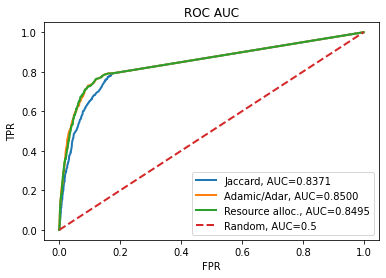

In [223]:
cases = [[jac[0], jac[1], 'Jaccard'], 
         [adam[0], adam[1], 'Adamic/Adar'], 
         [res[0], res[1], 'Resource alloc.']]
for fpr, tpr, label in cases:
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 6. DeepWalk graph embedding (2 points)

Consider DeepWalk embedding of Zachary's Karate Club graph. DeepWalk is an approach for learning latent representations of nodes in a network. These latent representations encode social relations in a continuous vector space, which is easily exploited by statistical models. The algorithm is divided into two steps:
1. Generate random walks
2. Encode a matrix of random walks into low-dimensional space using SkipGram architcture with Hierarchical Softmax

Write a function `random_walks` that takes a graph, number of random walks `n_walks` starting from every node, path length of walk `path_length`. The function returns a np.array of a shape `(n_walks * N, path_length)` where `N` is number of nodes and every row is a single random path.

In [181]:
def random_walks(G, n_walks, path_length):
    walks = []
    
    for node in G.nodes:
        for i in range(n_walks):
            walk = []
            next_node = node
            for j in range(path_length):
                walk.append(next_node)
                next_node = np.random.choice(list(G.neighbors(next_node)))
            walks.append(walk)
    
    return np.array(walks)

In [182]:
np.random.seed(0)
G = nx.karate_club_graph()
walks = random_walks(G, 10, 100)

assert walks.shape == (340, 100)
for i, j in zip(walks[0, :-1], walks[0, 1:]):
    assert G.has_edge(i, j)
assert np.all(walks[:, 0] == np.repeat(np.arange(34), 10))

Now let us apply Word2Vec model for embedding nodes into 2D space. 

Write a function `encode` that takes a np.array with random walks matrix, a graph `G` and returns positions of nodes — a dictionary where keys are nodes and values are np.arrays with 2D embedding.

_Hints:_
* _Convert the random walks matrix from np.array into list of lists with string entries_
* _Create a model `gensim.models.word2vec.Word2Vec` with 2D embedding (`size=2`)_
* _Make sure that Hierarchical Softmax is turn on (`hs=1`) and SkipGram is turn on (`sg=1`)_
* _Adjust parameters: window size `window`, learning rate `alpha`, number of epochs `iter`_
* _`model.wv` contains obtained 2D vectors_
* _Check the drawing: nodes should be close to each other if they have similar neighbors_

In [185]:
def encode(walks):
    walks_str = walks.astype('str').tolist()
    model = Word2Vec(size=2, alpha=1e-3, hs=1, sg=1, iter=100, window=3, seed=0)
    model.build_vocab(walks_str)
    total_examples = model.corpus_count
    model.train(walks_str, total_examples=total_examples, epochs=100)
    embedding = [model.wv[str(n)] for n in range(len(G))]
    pos = {i: emb for i, emb in enumerate(embedding)}
    return pos

In [186]:
pos = encode(walks)
assert type(pos) == dict
assert len(pos) == 34
assert pos[0].shape == (2,)
assert np.linalg.norm(pos[0] - pos[11]) < np.linalg.norm(pos[0] - pos[33])
assert np.linalg.norm(pos[1] - pos[2]) < np.linalg.norm(pos[1] - pos[32])

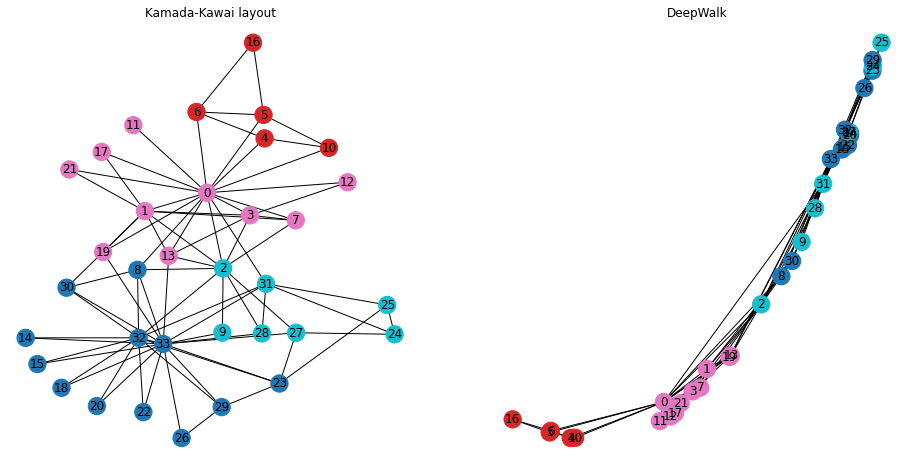

In [187]:
node_color = [2, 2, 3, 2, 1, 1, 1, 2, 0, 3, 1, 2, 2, 2, 
              0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 3, 3, 0, 3, 
              3, 0, 0, 3, 0, 0]

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
nx.draw_kamada_kawai(G, with_labels=True,
        node_color=node_color, cmap=plt.cm.tab10)
plt.title('Kamada-Kawai layout')
plt.subplot(1, 2, 2)
nx.draw(G, pos, with_labels=True,
        node_color=node_color, cmap=plt.cm.tab10)
plt.title('DeepWalk')
plt.show()